In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [61]:
df = pd.read_csv("./additional/TitanicDataset.csv")

In [3]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


PassengerId - id пассажира
Survived - выжил (1) / не выжил (0)
Pclass - класс билета (1, 2, 3)
Name - фамилия, имя
Sex - пол
Age - возраст
SibSp - количество братьев/сестёр или супругов на борту
Parch - количество родителей/детей на борту
Ticket - номер билета
Fare - стоимость билета
Cabin - номер каюты
Embarked - порт посадки

In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [62]:
# Приведём признак пол к числовому типу
sex_map = {'male': 0, 'female': 1}
df['Sex'] = list(map(lambda x: sex_map[x], df['Sex']))

Порты посадки: С - 0, Q - 1, S - 2, пропуск - (-1).

In [63]:
# Приведём признак порт посадки к числовому типу
df['Embarked'] = pd.Categorical(df['Embarked'])
df['Embarked'] = df['Embarked'].cat.codes

In [64]:
# Заполним пропуски в столбце age средним значением
df["Age"] = df["Age"].fillna(df["Age"].mean())

In [65]:
# Заполним пропуски в портах посадки самым частовстречающимся значением
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Столбец Cabin содержит слишком большое число пропусков, и нет возможности их как-то логично заполнить. Не будем использовать его при построении модели.

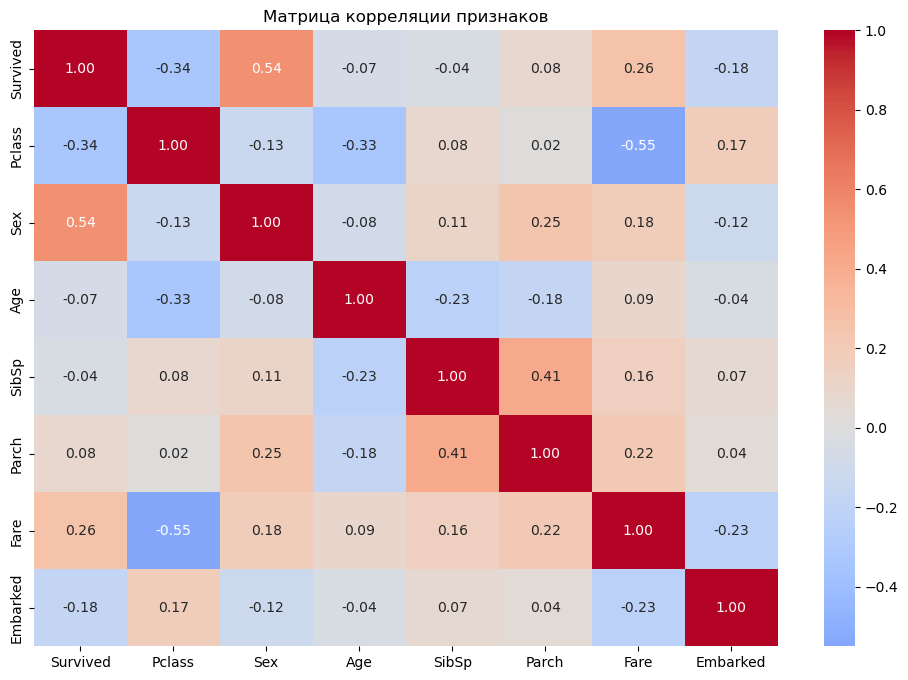

In [10]:
# Построим матрицу корреляции для числовых признаков
corr_matrix = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]].corr()

# визуализация с seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

In [11]:
# Отсортируем признаки по модулю корреляции с целевой переменной:
target_corr = corr_matrix['Survived'].sort_values(ascending=False)
target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

Survived    1.000000
Sex         0.543351
Pclass     -0.338481
Fare        0.257307
Embarked   -0.176509
Parch       0.081629
Age        -0.069809
SibSp      -0.035322
Name: Survived, dtype: float64

Pclass и Fare сильно коррелируют между собой, что логично, так как класс уже подразумевает определённую стоимость билета. Возьмём для модели только Pclass.

In [12]:
# выбор и нормализация признаков
# (метод масштабирования)
features = ["Sex", "Pclass", "Embarked", "Parch", "Age", "SibSp"]

for col in features:
    max_x = max(df[col])
    min_x = min(df[col])
    df[col] = (df[col] - min_x) / (max_x - min_x)

# Нормализация целевой перем.
df['Survived'] = (df['Survived'] - min(df['Survived'])) / (max(df['Survived']) - min(df['Survived']))

X = df[features].values.tolist()
y = df['Survived'].values.tolist()

In [13]:
# Разделим данные на train и test
indices = list(range(len(X)))
random.shuffle(indices) # перемешаем индексы, чтобы деление было случайным

split = int(0.8 * len(X))
train_idx = indices[:split]
test_idx = indices[split:]

X_train = [X[i] for i in train_idx]
y_train = [y[i] for i in train_idx]
X_test = [X[i] for i in test_idx]
y_test = [y[i] for i in test_idx]

In [14]:
# расчёт вероятности
def sigmoid(z):
    return 1 / (1 + pow(2.71828, -z))

In [15]:
# вычисление значение z (это наша линейная регрессия)
def calculate_z(x, weights):
    return sum([x[i] * weights[i] for i in range(len(x))])

In [16]:
# расчёт вероятности выживаемости
def predict(x, weights):
    return sigmoid(calculate_z(x, weights))

In [17]:
# вычисляем значение функции ошибки MSE
def calculate_mse(y_true, y_pred):
    return sum([(yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)]) / len(y_true)

In [18]:
# проверяем accuracy модели
def calculate_accuracy(y_true, y_pred):
    y_pred_class = [1 if p >= 0.5 else 0 for p in y_pred]
    correct = sum([1 for yt, yp in zip(y_true, y_pred_class) if yt == yp])
    return correct / len(y_true)

In [19]:
# учтём свободный член, добавив для него фиктивную переменную 1
X_train_bias = [[1.0] + row for row in X_train]
X_test_bias = [[1.0] + row for row in X_test]

In [20]:
# инициализация весов
weights = [0.0] * len(X_train_bias[0])

In [21]:
# градиентный спуск
lr = 0.1
epochs = 10000
errors = [] # список для хранения ошибки на каждой эпохе

for epoch in range(epochs):
    predictions = [predict(x, weights) for x in X_train_bias]
    gradients = [0.0] * len(weights)

    for i in range(len(X_train_bias)):
        error = predictions[i] - y_train[i]
        sigmoid_derivative = predictions[i] * (1 - predictions[i])
        for j in range(len(weights)):
            gradients[j] += error * sigmoid_derivative * X_train_bias[i][j]

    gradients = [g / len(X_train_bias) for g in gradients]

    # обновление весов
    weights = [weights[i] - lr * gradients[i] for i in range(len(weights))]

    # Вычисление ошибки
    error = calculate_mse(y_train, predictions)
    errors.append(error)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: MSE = {error:.4f}")

Epoch 0: MSE = 0.2500
Epoch 100: MSE = 0.2157
Epoch 200: MSE = 0.1991
Epoch 300: MSE = 0.1873
Epoch 400: MSE = 0.1786
Epoch 500: MSE = 0.1722
Epoch 600: MSE = 0.1675
Epoch 700: MSE = 0.1639
Epoch 800: MSE = 0.1611
Epoch 900: MSE = 0.1589
Epoch 1000: MSE = 0.1571
Epoch 1100: MSE = 0.1557
Epoch 1200: MSE = 0.1545
Epoch 1300: MSE = 0.1536
Epoch 1400: MSE = 0.1528
Epoch 1500: MSE = 0.1521
Epoch 1600: MSE = 0.1515
Epoch 1700: MSE = 0.1510
Epoch 1800: MSE = 0.1505
Epoch 1900: MSE = 0.1502
Epoch 2000: MSE = 0.1498
Epoch 2100: MSE = 0.1495
Epoch 2200: MSE = 0.1492
Epoch 2300: MSE = 0.1490
Epoch 2400: MSE = 0.1487
Epoch 2500: MSE = 0.1485
Epoch 2600: MSE = 0.1483
Epoch 2700: MSE = 0.1481
Epoch 2800: MSE = 0.1480
Epoch 2900: MSE = 0.1478
Epoch 3000: MSE = 0.1477
Epoch 3100: MSE = 0.1475
Epoch 3200: MSE = 0.1474
Epoch 3300: MSE = 0.1473
Epoch 3400: MSE = 0.1472
Epoch 3500: MSE = 0.1471
Epoch 3600: MSE = 0.1470
Epoch 3700: MSE = 0.1468
Epoch 3800: MSE = 0.1468
Epoch 3900: MSE = 0.1467
Epoch 4000: 

In [22]:
weights

[0.5178252011600586,
 2.6482021715998436,
 -1.7306652415703023,
 -0.7276726355469637,
 -0.4532304858127866,
 -0.9829154300771653,
 -0.7726121724256404]

In [23]:
# оценим модель
test_predictions = [predict(x, weights) for x in X_test_bias]
mse_test = calculate_mse(y_test, test_predictions)
acc_test = calculate_accuracy(y_test, test_predictions)

train_predictions = [predict(x, weights) for x in X_train_bias]
mse_train = calculate_mse(y_train, train_predictions)
acc_train = calculate_accuracy(y_train, train_predictions)

print(f"\nTrain MSE: {mse_train:.4f}")
print(f"Train Accuracy: {acc_train:.4f}")

print(f"\nTest MSE: {mse_test:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")


Train MSE: 0.1437
Train Accuracy: 0.7978

Test MSE: 0.1392
Test Accuracy: 0.7877


Сравним с решением от scikit learn:

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [27]:
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]

acc = accuracy_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred_proba)

print(f"Train Accuracy (sklearn): {acc:.4f}")
print(f"Train MSE (sklearn): {mse:.4f}")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_proba)

print(f"Test Accuracy (sklearn): {acc:.4f}")
print(f"Test MSE (sklearn): {mse:.4f}")

Train Accuracy (sklearn): 0.8020
Train MSE (sklearn): 0.1393
Test Accuracy (sklearn): 0.7877
Test MSE (sklearn): 0.1468


И моё, и коробочное решение показывают немного лучшую сходимость на тренировочных данных, что говорит о том, что модель начала переобучаться.

In [ ]:
Теперь нарочно недообучим модель, дав ей мало признаков и малое число итераций.

In [29]:
%reset -f

In [83]:
features_underfit = ["Parch", "SibSp"] # оставили НЕ самые информативные признаки
X = df[features_underfit]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_underfit = LogisticRegression(max_iter = 20) # ограничим итерации
model_underfit.fit(X_train, y_train)

y_pred = model_underfit.predict(X_train)
y_pred_proba = model_underfit.predict_proba(X_train)[:, 1]

acc = accuracy_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred_proba)

print(f"Train Accuracy (sklearn): {acc:.4f}")
print(f"Train MSE (sklearn): {mse:.4f}")

y_pred = model_underfit.predict(X_test)
y_pred_proba = model_underfit.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_proba)

print(f"Test Accuracy (sklearn): {acc:.4f}")
print(f"Test MSE (sklearn): {mse:.4f}")

Train Accuracy (sklearn): 0.6264
Train MSE (sklearn): 0.2337
Test Accuracy (sklearn): 0.6089
Test MSE (sklearn): 0.2330


Модель получила на вход всего два параметра, имеющих довольно низкую корреляцию с целевой переменной, а также число итераций было ограничено до 20. В результате модель недообучилась и показывает плохие результаты как на тренировочных, так и на тестовых данных.

In [59]:
%reset -f

In [82]:
features_fit = ["Sex", "Pclass", "Parch", "Age"]
X = df[features_fit]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_fit = LogisticRegression()
model_fit.fit(X_train, y_train)

y_pred = model_fit.predict(X_train)
y_pred_proba = model_fit.predict_proba(X_train)[:, 1]

acc = accuracy_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred_proba)

print(f"Train Accuracy (sklearn): {acc:.4f}")
print(f"Train MSE (sklearn): {mse:.4f}")

y_pred = model_fit.predict(X_test)
y_pred_proba = model_fit.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred_proba)

print(f"Test Accuracy (sklearn): {acc:.4f}")
print(f"Test MSE (sklearn): {mse:.4f}")

Train Accuracy (sklearn): 0.7907
Train MSE (sklearn): 0.1410
Test Accuracy (sklearn): 0.7933
Test MSE (sklearn): 0.1495


В данном случае точность и на обучающих, и на тестовых данных практически совпадает (было выбрано оптимальное число наиболее значимых параметров и количество итераций никак не ограничено (sklearn подберёт оптимальное, до сходимости)).